In [103]:
import cv2 as cv
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.preprocessing import StandardScaler
from skimage.restoration import denoise_wavelet, estimate_sigma
from skimage import img_as_float
from skimage.segmentation import chan_vese
from skimage import img_as_float

In [104]:
def Fetch_Images_Data(directory = "./ships-aerial-images/train_kepin/"):
  trep_images   = []
  for path in os.listdir(directory):
    img = cv.imread(directory+path)
    if img is not None:
      trep_images.append(img)
  return trep_images

dataset = Fetch_Images_Data()

In [105]:
#preprocessing
def preProcess(img,threshold= 1, thresh = -30):
    sigma_est = estimate_sigma(img, channel_axis=-1, average_sigmas=True)
    im_visushrink = denoise_wavelet(img,channel_axis=-1,convert2ycbcr=True,method='VisuShrink', 
                                    mode='soft', sigma=sigma_est/threshold, rescale_sigma=True)
    floatimage = np.clip((im_visushrink * 255), 0, 255)
    H, S, V = cv.split(cv.cvtColor(floatimage.astype(np.uint8), cv.COLOR_BGR2HSV))
    clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    res_channel = clahe.apply(np.uint8(V))
    img = cv.cvtColor(cv.merge([H,S,res_channel]), cv.COLOR_HSV2BGR)
    L, A, B = cv.split(cv.cvtColor(img, cv.COLOR_BGR2LAB))
    L_enhanced = np.clip(cv.add(L, thresh), 0, 255)
    lab_enhanced = cv.merge([L_enhanced, A, B])
    img = cv.cvtColor(lab_enhanced, cv.COLOR_LAB2BGR)
    return img

img = dataset[25]
img = preProcess(img)


In [117]:
#feature extraction
def Compute_Superpixel_Features(features, segments):
    unique_segments = np.unique(segments)
    superpixel_features = []

    for seg in unique_segments:
        mask = (segments == seg)
        segment_features = features[mask.flatten()]
        mean_feature = segment_features.mean(axis=0)
        superpixel_features.append(mean_feature)

    return np.array(superpixel_features)

def Get_Color_Features_1(img, method, segments):
	H, S, V = cv.split(cv.cvtColor(img, cv.COLOR_BGR2HSV))
	color_features = np.stack([H.flatten(), S.flatten()], axis=-1)
	scaler_color = StandardScaler()
	color_features_standardized = scaler_color.fit_transform(color_features)
	if method == "raw":
		return color_features_standardized
	elif method == "spx":
		superpixel_color_features = Compute_Superpixel_Features(color_features_standardized, segments.flatten())
		return superpixel_color_features
	else:
		raise ValueError("INVALID METHOD")

def Get_Color_Features_2(img, method, segments):
	L, A, B = cv.split(cv.cvtColor(img, cv.COLOR_BGR2LAB))
	color_features = np.stack([A.flatten(), B.flatten()], axis=-1)
	scaler_color = StandardScaler()
	color_features_standardized = scaler_color.fit_transform(color_features)
	if method == "raw":
		return color_features_standardized
	elif method == "spx":
		superpixel_color_features = Compute_Superpixel_Features(color_features_standardized, segments.flatten())
		return superpixel_color_features
	else:
		raise ValueError("INVALID METHOD")

def Create_GaborFilters_Bank():
	filters = []
	ksize = 50
	sigma = 3
	theta = 1*np.pi/4
	lamda = 5
	gamma = 0.5
	phi = 0
	theta_list = [
		0.0 * theta, 0.25 * theta, 0.5 * theta, 0.75 * theta,
		1.0 * theta, 1.25 * theta, 1.5 * theta, 1.75 * theta,
		2.0 * theta, 2.25 * theta, 2.5 * theta, 2.75 * theta,
		3.0 * theta, 3.25 * theta, 3.5 * theta, 3.75 * theta
	]
	lamda_list = [lamda*i for i in range(1, 17)]

	for thetas in theta_list:
		for lamdas in lamda_list:
			kernel = cv.getGaborKernel((ksize,ksize),sigma,thetas,lamdas,gamma,phi,ktype = cv.CV_32F)
			filters.append(kernel)
	return filters

def Apply_Gabor_Filters(image, filters):
    responses = []
    for kernel in filters:
        filtered = cv.filter2D(image, cv.CV_32F, kernel)
        responses.append(filtered)
    return responses

def combine_gabor_features(responses):
    feature_stack = np.stack(responses, axis=-1)
    feature_vector = feature_stack.reshape(-1, len(responses))
    return feature_vector

def Get_Texture_Features(img, method, segments):
	H, S, V = cv.split(cv.cvtColor(img, cv.COLOR_BGR2HSV))
	GaborFilters_list = Create_GaborFilters_Bank()
	gab_resp = Apply_Gabor_Filters(V,GaborFilters_list)
	texture_features = combine_gabor_features(gab_resp)
	scaler_texture = StandardScaler()
	texture_features_standardized = scaler_texture.fit_transform(texture_features)
	if method == "raw":
		return texture_features_standardized
	elif method == "spx":
		superpixel_texture_features = Compute_Superpixel_Features(texture_features_standardized, segments.flatten())
		return superpixel_texture_features
	else:
		raise ValueError("INVALID METHOD")

def Get_Edge_Features(img,method,segments):
	gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
	edge_features = cv.Canny(gray, threshold1=200, threshold2=300, apertureSize=3, L2gradient=True)
	edge_features = edge_features.flatten()
	edge_features = edge_features.reshape(-1, 1)
	scaler_edge = StandardScaler()
	edge_features_standardized = scaler_edge.fit_transform(edge_features)
	if method == "raw":
		return edge_features_standardized
	elif method == "spx":
		superpixel_edge_features = Compute_Superpixel_Features(edge_features_standardized, segments.flatten())
		return superpixel_edge_features
	else:
		raise ValueError("INVALID METHOD")

def Get_Superpixel_Segments(img, method):
    if method == "SLIC":
        LAB_img = cv.cvtColor(img,cv.COLOR_BGR2LAB)
        slic = cv.ximgproc.createSuperpixelSLIC(LAB_img, algorithm=cv.ximgproc.SLIC, region_size=30, ruler=18.5)
        slic.iterate(10)
        segments = slic.getLabels()
    elif method == "SEEDS":
        LAB_img = cv.cvtColor(img,cv.COLOR_BGR2LAB)
        num_superpixels = 800
        num_levels = 4
        width, height, channels = LAB_img.shape[1], LAB_img.shape[0], LAB_img.shape[2]
        seeds = cv.ximgproc.createSuperpixelSEEDS(width, height, channels, num_superpixels, num_levels)
        seeds.iterate(LAB_img, 160)
        segments = seeds.getLabels()
    elif method == "LSC":
        LAB_img = cv.cvtColor(img,cv.COLOR_BGR2LAB)
        lsc = cv.ximgproc.createSuperpixelLSC(LAB_img, region_size=30, ratio=0.065)
        lsc.iterate(10)
        segments = lsc.getLabels()
    else:
        raise ValueError("INVALID METHOD")
    return segments

def Get_Weighted_Features(img, fweight1, fweight2, fweight3, fweight4, feat_type, last = None):
	feature1 = Get_Color_Features_1(img,feat_type,last)
	feature2 = Get_Color_Features_2(img,feat_type,last)
	feature3 = Get_Texture_Features(img,feat_type,last)
	feature4 = Get_Edge_Features(img,feat_type,last)
  
	weighted_features = np.hstack([
		feature1 * fweight1,
		feature2 * fweight2,
		feature3 * fweight3,
		feature4 * fweight4
	])
	return weighted_features

weighted_features_raw = Get_Weighted_Features(img ,0.9,0.9,0.1,0.9, "raw")

segments = Get_Superpixel_Segments(img,"SEEDS")
weighted_features_spx = Get_Weighted_Features(img, 0.9,0.9,0.1,0.9, "spx", segments)

In [112]:
#load model
import pickle

def plot_comparison(original_image,segmented_image, segmentation_chanvese):
	plt.figure(figsize=(15, 10))
	plt.subplot(1, 3, 1)
	plt.imshow(cv.cvtColor(original_image, cv.COLOR_BGR2RGB))
	plt.title("Original Image")
	plt.axis('off')
	plt.subplot(1, 3, 2)
	plt.imshow(segmented_image, cmap='jet')
	plt.title("Sea-Land Segmentation")
	plt.axis('off')
	plt.subplot(1, 3, 3)
	plt.imshow(segmentation_chanvese, cmap='gray')
	plt.title("Refined Segmentation with Chan-Vese")
	plt.axis('off')
	plt.show()
	return

with open("./fcm.pkl", 'rb') as f: fcm = pickle.load(f)
with open("./fcm-superpixel.pkl", 'rb') as f1: fcm_superpixel = pickle.load(f1)
with open("./kmeans.pkl", 'rb') as f2: kmeans = pickle.load(f2)

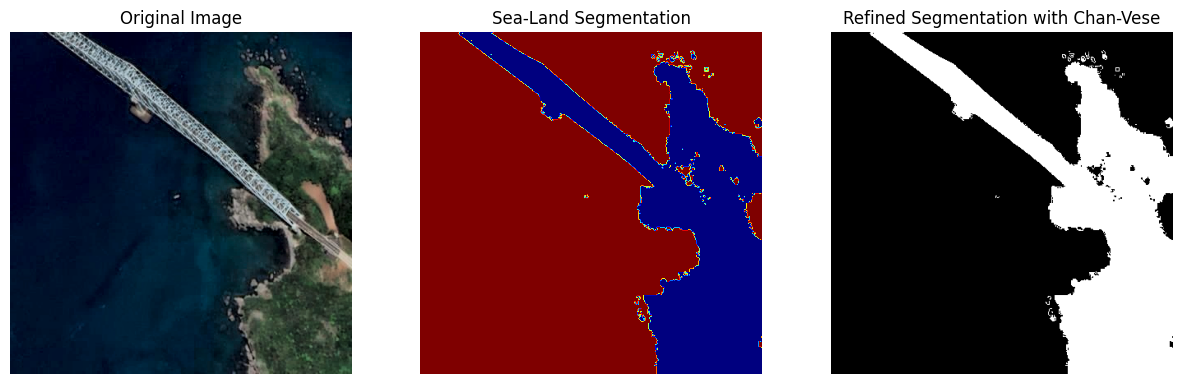

In [119]:
labels = kmeans.predict(weighted_features_raw)
segmented_image = labels.reshape(img.shape[:2])
image_float = img_as_float(segmented_image)
segmentation_chanvese = chan_vese(image_float, mu=0.25, lambda1=1, lambda2=1, max_num_iter=200, tol=1e-3)
plot_comparison(img, segmented_image, segmentation_chanvese)

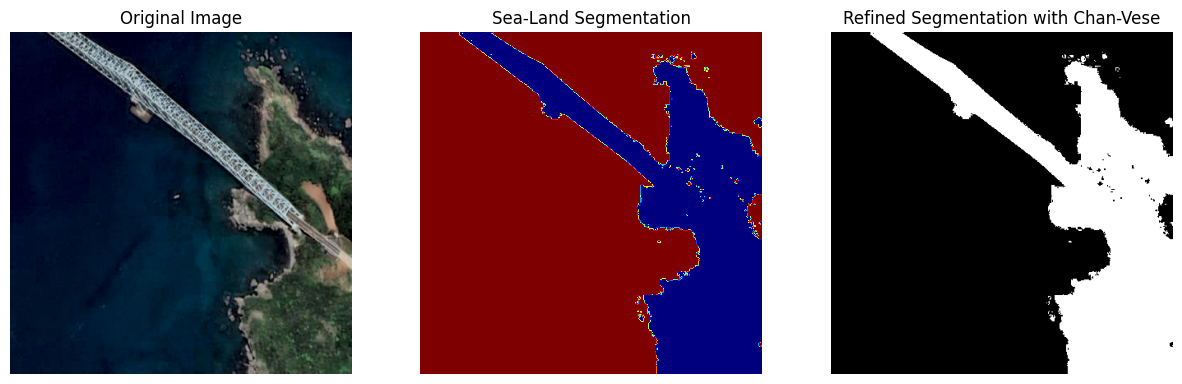

In [120]:
labels = fcm.predict(weighted_features_raw)
segmented_image = labels.reshape(img.shape[:2])
image_float = img_as_float(segmented_image)
segmentation_chanvese = chan_vese(image_float, mu=0.25, lambda1=1, lambda2=1, max_num_iter=200, tol=1e-3)
plot_comparison(img, segmented_image, segmentation_chanvese)


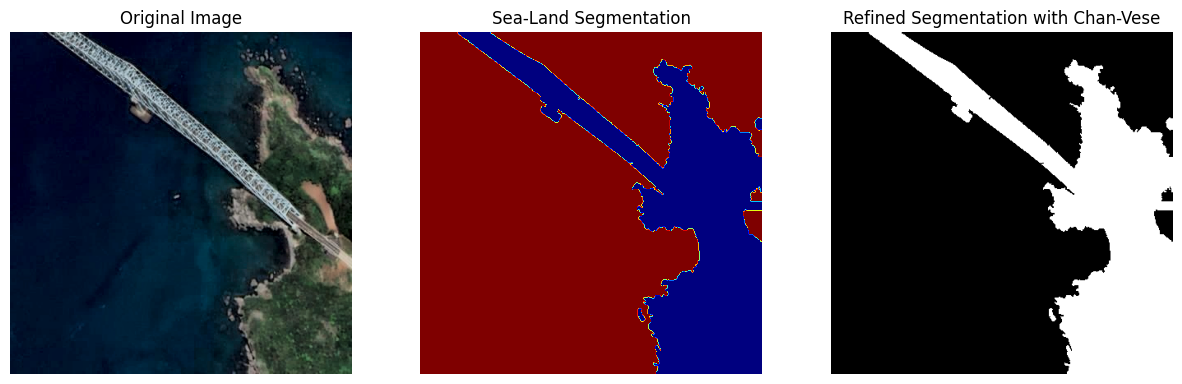

In [118]:
labels = fcm_superpixel.predict(weighted_features_spx)
segmented_image = np.zeros_like(segments)
segments = Get_Superpixel_Segments(img,"SEEDS")

segmented_image = np.zeros_like(segments)
for seg, label in zip(np.unique(segments), labels):
    segmented_image[segments == seg] = label
    
image_float = img_as_float(segmented_image)
segmentation_chanvese = chan_vese(image_float, mu=0.25, lambda1=1, lambda2=1, max_num_iter=200, tol=1e-3)

plot_comparison(img,segmented_image, segmentation_chanvese)
